In [1]:
# pip install -q -U keras-tuner

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras_tuner as kt

2.7.0


In [2]:
%store -r IMBALANCED_TRAIN_VAL 
%store -r RESAMPLED_TRAIN_VAL 
%store -r TEST 
imbalanced_train_val=IMBALANCED_TRAIN_VAL.copy()
resampled_train_val= RESAMPLED_TRAIN_VAL.copy()
test= TEST.copy()

In [3]:
print(imbalanced_train_val.shape, 'imbalanced_train_val examples')
print(resampled_train_val.shape, 'resampled_train_val examples')
print(test.shape, 'test examples')

(82332, 43) imbalanced_train_val examples
(370000, 43) resampled_train_val examples
(175341, 43) test examples


In [4]:
imbalanced_train,imbalanced_val = train_test_split(imbalanced_train_val, test_size=0.2, random_state = 1)
resampled_train,resampled_val = train_test_split(resampled_train_val, test_size=0.2, random_state = 1)
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
BATCH_SIZE = 32
EPOCHS = 100
MODELS_RESULTS={}
N_TRAIN=len(imbalanced_train)
N_RES_TRAIN=len(resampled_train)
N_VAL=len(imbalanced_val)
N_RES_VAL=len(resampled_val)
N_TEST=len(test)
print('___TEST________________________________________________')
print(test.shape, 'test shape')
print(N_TEST, 'test count')
print('________________________________________________________')
print('___IMBALANCED___________________________________________')
print(imbalanced_train_val.shape, 'training shape')
print(N_TRAIN, 'training examples')
print(N_VAL, 'validation examples')
print('_________________________________________________________')
print('___BALANCED______________________________________________')
print(resampled_train_val.shape, 'training shape')
print(N_RES_TRAIN, 'training examples')
print(N_RES_VAL, 'validation examples')
print('_________________________________________________________')
print(CLASSES)

___TEST________________________________________________
(175341, 43) test shape
175341 test count
________________________________________________________
___IMBALANCED___________________________________________
(82332, 43) training shape
65865 training examples
16467 validation examples
_________________________________________________________
___BALANCED______________________________________________
(370000, 43) training shape
296000 training examples
74000 validation examples
_________________________________________________________
['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [5]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [6]:
regularizers=tf.keras.regularizers.l2(0.001)
def group_dtype(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result
    
def plot_model_graph(history,name):
    plt.figure(figsize=(8, 30))
    names =['loss','accuracy','precision','recall','prc','auc']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

def dataframe_to_dataset(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [7]:
_col = group_dtype(imbalanced_train) # return result from
number_col=_col['number_col']
string_category_col=_col['string_category_col']
int_category_col=_col['int_category_col']

In [8]:
dataframe = imbalanced_train.copy()
_ds= dataframe_to_dataset(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]
classes = 10
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(X[0])
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(X[1])
string_vocabulary=string_lookup.get_vocabulary()
# Create a Intlookup layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(X[2])
int_vocabulary=int_lookup.get_vocabulary()

In [9]:
def evaluation(model,train_ds,val_ds,test_ds,name):
    X_train,y_train=train_ds
    X_val,y_val=val_ds
    X_test,y_test=test_ds
    project_name='HYPERPARAM_'+name
    tuner = kt.Hyperband(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
    
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete for {name}. The optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)
    summary=tuner.results_summary(num_trials=1)
    print("summary data")
    print(summary)
    best_model=tuner.get_best_models(num_models=1)
    print("best model data")
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
#   Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)
    # Retrain the model
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
    MODELS_RESULTS[name]={}
    print('----')
    print('----')
    print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
    MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
    MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
    MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('plot:{}_________________________________________________________'.format(name))
    plot_model_graph(history,name)
    return hypermodel

In [10]:
# # Load some data
def build_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
    # include the normalization layer
    x1 = normalizer(input_num)
    # dence layers for numeric data
    hp_units_num_1 = hp.Int('units_num_1', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_1,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_2 = hp.Int('units_num_2', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_2,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_3 = hp.Int('units_num_3', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_3,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    output_num = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x1)
    model_1=keras.models.Model(inputs=input_num, outputs=output_num)
    print('SUBMODAL-INTEGER-NUMERIC')
    model_1.summary()
    y1= model_1(input_num)
    
  # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
  # include the int_lookup layer
    x2 = int_lookup(input_int)
  # dence layers for integer data
    hp_units_int_1 = hp.Int('units_int_1', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_1,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_2 = hp.Int('units_int_2', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_2,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_3 = hp.Int('units_int_3', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_3,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)

    output_int = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x2)
    model_2=keras.models.Model(inputs=input_int, outputs=output_int)
    print('SUBMODAL-INTEGER-SUMMARY')
    model_2.summary()
    y2= model_2(input_int)
    
  # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
  # include the int_lookup layer
    x3 = string_lookup(input_string)
  # dence layers for string data
    hp_units_string_1 = hp.Int('units_string_1', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_1,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    hp_units_string_2 = hp.Int('units_string_2', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_2,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    
    hp_units_string_3 = hp.Int('units_string_3', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_3,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    output_string = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x3)
    model_3=keras.models.Model(inputs=input_string, outputs=output_string)
    print('SUBMODAL-STRING-SUMMARY')
    model_3.summary()
    y3= model_3(input_string)
    
    avg = tf.keras.layers.Average()([y1,y2,y3])
    output = layers.Dense(classes, activation="softmax")(avg)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

LATE-FUSION-IMBALANCED
INFO:tensorflow:Reloading Oracle from existing project hyperparam_dir/HYPERPARAM_LATE-FUSION-IMBALANCED/oracle.json
SUBMODAL-INTEGER-NUMERIC
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_inputs (InputLayer)  [(None, 11)]             0         
                                                                 
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_26 (Dense)            (None, 32)                384       
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                           

SUBMODAL-STRING-SUMMARY
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cartegory_string_inputs (In  [(None, 3)]              0         
 putLayer)                                                       
                                                                 
 string_lookup (StringLookup  (None, 152)              0         
 )                                                               
                                                                 
 dense_8 (Dense)             (None, 192)               29376     
                                                                 
 dropout_6 (Dropout)         (None, 192)               0         
                                                                 
 dense_9 (Dense)             (None, 192)               37056     
                                                                 
 dropout_7 (Dropout)         (None,

Epoch 32/100
2059/2059 [==============================] - 547s 266ms/step - loss: 0.5174 - accuracy: 0.8394 - precision: 0.9198 - recall: 0.7846 - auc: 0.9898 - prc: 0.9387 - val_loss: 0.5272 - val_accuracy: 0.8369 - val_precision: 0.9147 - val_recall: 0.7813 - val_auc: 0.9889 - val_prc: 0.9361
Epoch 33/100
2059/2059 [==============================] - 544s 264ms/step - loss: 0.5167 - accuracy: 0.8394 - precision: 0.9195 - recall: 0.7853 - auc: 0.9898 - prc: 0.9389 - val_loss: 0.5337 - val_accuracy: 0.8317 - val_precision: 0.9120 - val_recall: 0.7782 - val_auc: 0.9885 - val_prc: 0.9340
Epoch 34/100
2059/2059 [==============================] - 556s 270ms/step - loss: 0.5160 - accuracy: 0.8410 - precision: 0.9195 - recall: 0.7858 - auc: 0.9898 - prc: 0.9391 - val_loss: 0.5294 - val_accuracy: 0.8365 - val_precision: 0.9132 - val_recall: 0.7816 - val_auc: 0.9888 - val_prc: 0.9355
Epoch 35/100
2059/2059 [==============================] - 551s 268ms/step - loss: 0.5142 - accuracy: 0.8416 - pr

Epoch 60/100
2059/2059 [==============================] - 501s 243ms/step - loss: 0.4941 - accuracy: 0.8474 - precision: 0.9251 - recall: 0.7926 - auc: 0.9910 - prc: 0.9444 - val_loss: 0.5183 - val_accuracy: 0.8382 - val_precision: 0.9152 - val_recall: 0.7868 - val_auc: 0.9895 - val_prc: 0.9383
Epoch 61/100
2059/2059 [==============================] - 509s 247ms/step - loss: 0.4925 - accuracy: 0.8476 - precision: 0.9256 - recall: 0.7944 - auc: 0.9910 - prc: 0.9449 - val_loss: 0.5174 - val_accuracy: 0.8402 - val_precision: 0.9183 - val_recall: 0.7844 - val_auc: 0.9895 - val_prc: 0.9387
Epoch 62/100
2059/2059 [==============================] - 529s 257ms/step - loss: 0.4931 - accuracy: 0.8493 - precision: 0.9262 - recall: 0.7942 - auc: 0.9910 - prc: 0.9446 - val_loss: 0.5152 - val_accuracy: 0.8402 - val_precision: 0.9200 - val_recall: 0.7847 - val_auc: 0.9896 - val_prc: 0.9390
Epoch 63/100
2059/2059 [==============================] - 539s 262ms/step - loss: 0.4934 - accuracy: 0.8478 - pr

fit model for:LATE-FUSION-IMBALANCED_____________________________________________________________________________________________________________
Epoch 1/98
2059/2059 [==============================] - 507s 240ms/step - loss: 1.8216 - accuracy: 0.7561 - precision: 0.8969 - recall: 0.6530 - auc: 0.9701 - prc: 0.8589 - val_loss: 1.0997 - val_accuracy: 0.7944 - val_precision: 0.8910 - val_recall: 0.7110 - val_auc: 0.9795 - val_prc: 0.8957
Epoch 2/98
2059/2059 [==============================] - 488s 237ms/step - loss: 0.9276 - accuracy: 0.8067 - precision: 0.9072 - recall: 0.7297 - auc: 0.9813 - prc: 0.9041 - val_loss: 0.7836 - val_accuracy: 0.8105 - val_precision: 0.9163 - val_recall: 0.7302 - val_auc: 0.9844 - val_prc: 0.9156
Epoch 3/98
2059/2059 [==============================] - 485s 235ms/step - loss: 0.7340 - accuracy: 0.8129 - precision: 0.9119 - recall: 0.7439 - auc: 0.9840 - prc: 0.9150 - val_loss: 0.6749 - val_accuracy: 0.8177 - val_precision: 0.9172 - val_recall: 0.7397 - val_au

Epoch 56/98
2059/2059 [==============================] - 546s 265ms/step - loss: 0.4924 - accuracy: 0.8486 - precision: 0.9275 - recall: 0.7956 - auc: 0.9907 - prc: 0.9440 - val_loss: 0.5166 - val_accuracy: 0.8376 - val_precision: 0.9185 - val_recall: 0.7830 - val_auc: 0.9895 - val_prc: 0.9372
Epoch 57/98
2059/2059 [==============================] - 587s 285ms/step - loss: 0.4916 - accuracy: 0.8481 - precision: 0.9287 - recall: 0.7971 - auc: 0.9909 - prc: 0.9442 - val_loss: 0.5144 - val_accuracy: 0.8381 - val_precision: 0.9217 - val_recall: 0.7834 - val_auc: 0.9896 - val_prc: 0.9381
Epoch 58/98
2059/2059 [==============================] - 530s 257ms/step - loss: 0.4921 - accuracy: 0.8483 - precision: 0.9281 - recall: 0.7968 - auc: 0.9908 - prc: 0.9440 - val_loss: 0.5124 - val_accuracy: 0.8388 - val_precision: 0.9193 - val_recall: 0.7868 - val_auc: 0.9897 - val_prc: 0.9385
Epoch 59/98
2059/2059 [==============================] - 548s 266ms/step - loss: 0.4899 - accuracy: 0.8493 - precis

Epoch 84/98
2059/2059 [==============================] - 534s 259ms/step - loss: 0.4790 - accuracy: 0.8531 - precision: 0.9318 - recall: 0.8015 - auc: 0.9914 - prc: 0.9471 - val_loss: 0.5135 - val_accuracy: 0.8394 - val_precision: 0.9162 - val_recall: 0.7904 - val_auc: 0.9893 - val_prc: 0.9382
Epoch 85/98
2059/2059 [==============================] - 547s 266ms/step - loss: 0.4782 - accuracy: 0.8514 - precision: 0.9307 - recall: 0.8000 - auc: 0.9914 - prc: 0.9470 - val_loss: 0.5113 - val_accuracy: 0.8393 - val_precision: 0.9165 - val_recall: 0.7896 - val_auc: 0.9894 - val_prc: 0.9386
Epoch 86/98
2059/2059 [==============================] - 547s 266ms/step - loss: 0.4780 - accuracy: 0.8515 - precision: 0.9317 - recall: 0.8007 - auc: 0.9913 - prc: 0.9472 - val_loss: 0.5083 - val_accuracy: 0.8407 - val_precision: 0.9206 - val_recall: 0.7864 - val_auc: 0.9897 - val_prc: 0.9395
Epoch 87/98
2059/2059 [==============================] - 512s 248ms/step - loss: 0.4764 - accuracy: 0.8525 - precis

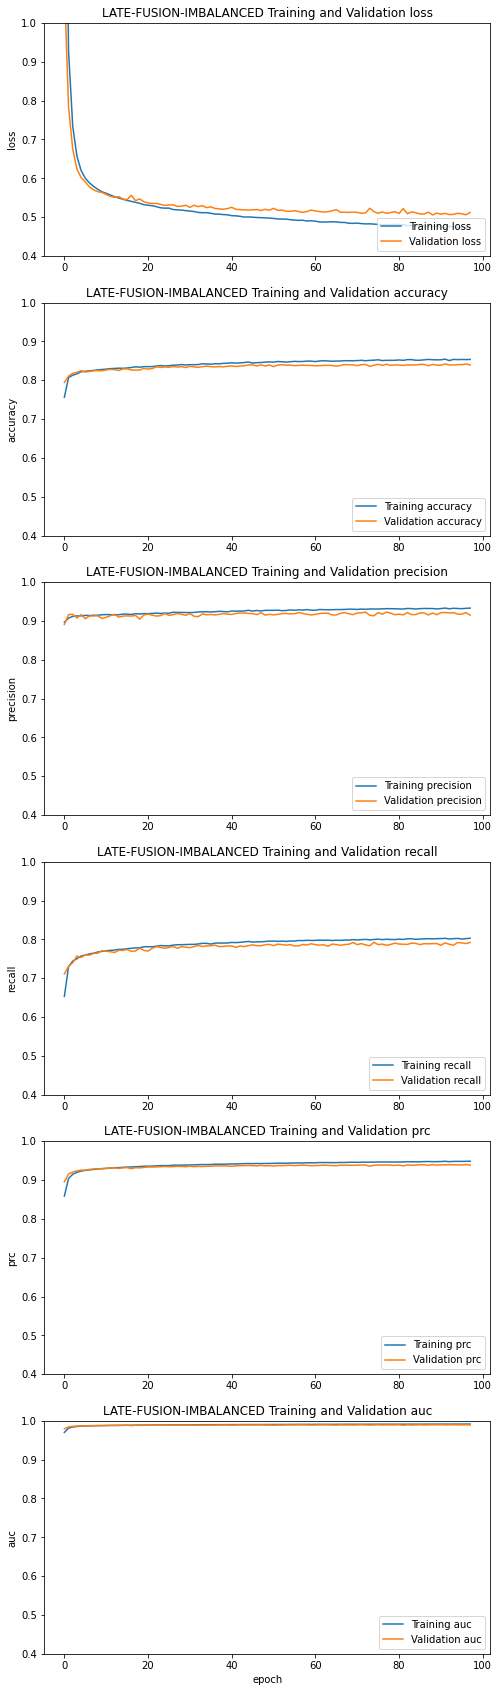

In [40]:
# LATE-FUSION-IMBALANCED
dataframe = imbalanced_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = imbalanced_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)

print('LATE-FUSION-IMBALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'LATE-FUSION-IMBALANCED')


Trial 31 Complete [09h 59m 02s]
val_accuracy: 0.699986457824707

Best val_accuracy So Far: 0.7012162208557129
Total elapsed time: 20h 29m 37s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for LATE-FUSION-BALANCED. The optimal learning rate for the optimizer
    is 0.0001.
    
Results summary
Results in hyperparam_dir/HYPERPARAM_LATE-FUSION-BALANCED
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
units_num_1: 160
units_num_2: 512
units_num_3: 64
units_int_1: 224
units_int_2: 128
units_int_3: 192
units_string_1: 64
units_string_2: 416
units_string_3: 416
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7012162208557129
summary data
None
SUBMODAL-INTEGER-NUMERIC
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_inputs (InputLayer)  [(None, 11)]

SUBMODAL-STRING-SUMMARY
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cartegory_string_inputs (In  [(None, 3)]              0         
 putLayer)                                                       
                                                                 
 string_lookup (StringLookup  (None, 152)              0         
 )                                                               
                                                                 
 dense_21 (Dense)            (None, 64)                9792      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 416)               27040     
                                                                 
 dropout_16 (Dropout)        (None,

9250/9250 [==============================] - 1721s 186ms/step - loss: 0.8725 - accuracy: 0.7074 - precision: 0.8588 - recall: 0.5691 - auc: 0.9676 - prc: 0.8246 - val_loss: 0.8405 - val_accuracy: 0.7183 - val_precision: 0.8716 - val_recall: 0.5815 - val_auc: 0.9701 - val_prc: 0.8361
Epoch 50/100
9250/9250 [==============================] - 1677s 181ms/step - loss: 0.8719 - accuracy: 0.7075 - precision: 0.8601 - recall: 0.5680 - auc: 0.9676 - prc: 0.8248 - val_loss: 0.8418 - val_accuracy: 0.7178 - val_precision: 0.8593 - val_recall: 0.5850 - val_auc: 0.9700 - val_prc: 0.8353
Epoch 51/100
9250/9250 [==============================] - 1715s 185ms/step - loss: 0.8706 - accuracy: 0.7076 - precision: 0.8594 - recall: 0.5706 - auc: 0.9677 - prc: 0.8253 - val_loss: 0.8394 - val_accuracy: 0.7177 - val_precision: 0.8656 - val_recall: 0.5833 - val_auc: 0.9701 - val_prc: 0.8362
Epoch 52/100
9250/9250 [==============================] - 1733s 187ms/step - loss: 0.8712 - accuracy: 0.7076 - precision: 

SUBMODAL-INTEGER-SUMMARY
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cartegory_integer_inputs (I  [(None, 28)]             0         
 nputLayer)                                                      
                                                                 
 integer_lookup (IntegerLook  (None, 70605)            0         
 up)                                                             
                                                                 
 dense_30 (Dense)            (None, 224)               15815744  
                                                                 
 dropout_21 (Dropout)        (None, 224)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               28800     
                                                                 
 dropout_22 (Dropout)        (None

9250/9250 [==============================] - 2017s 218ms/step - loss: 0.8802 - accuracy: 0.7057 - precision: 0.8538 - recall: 0.5699 - auc: 0.9672 - prc: 0.8226 - val_loss: 0.8483 - val_accuracy: 0.7158 - val_precision: 0.8626 - val_recall: 0.5814 - val_auc: 0.9698 - val_prc: 0.8336
Epoch 44/93
9250/9250 [==============================] - 2137s 231ms/step - loss: 0.8790 - accuracy: 0.7059 - precision: 0.8538 - recall: 0.5706 - auc: 0.9673 - prc: 0.8229 - val_loss: 0.8459 - val_accuracy: 0.7182 - val_precision: 0.8646 - val_recall: 0.5828 - val_auc: 0.9698 - val_prc: 0.8354
Epoch 45/93
9250/9250 [==============================] - 1969s 213ms/step - loss: 0.8789 - accuracy: 0.7054 - precision: 0.8543 - recall: 0.5705 - auc: 0.9673 - prc: 0.8229 - val_loss: 0.8459 - val_accuracy: 0.7164 - val_precision: 0.8610 - val_recall: 0.5847 - val_auc: 0.9697 - val_prc: 0.8345
Epoch 46/93
9250/9250 [==============================] - 2025s 219ms/step - loss: 0.8778 - accuracy: 0.7058 - precision: 0.8

5480/5480 [==============================] - 268s 49ms/step - loss: 0.8303 - accuracy: 0.7320 - precision: 0.8524 - recall: 0.6877 - auc: 0.9707 - prc: 0.8593
loss:0.8302690982818604 -accuracy:0.7320250272750854 - precision:0.8523927330970764 - recall:0.6877341866493225 - auc:0.9707029461860657 - prc:0.8592696189880371
----
----
plot:LATE-FUSION-BALANCED_________________________________________________________


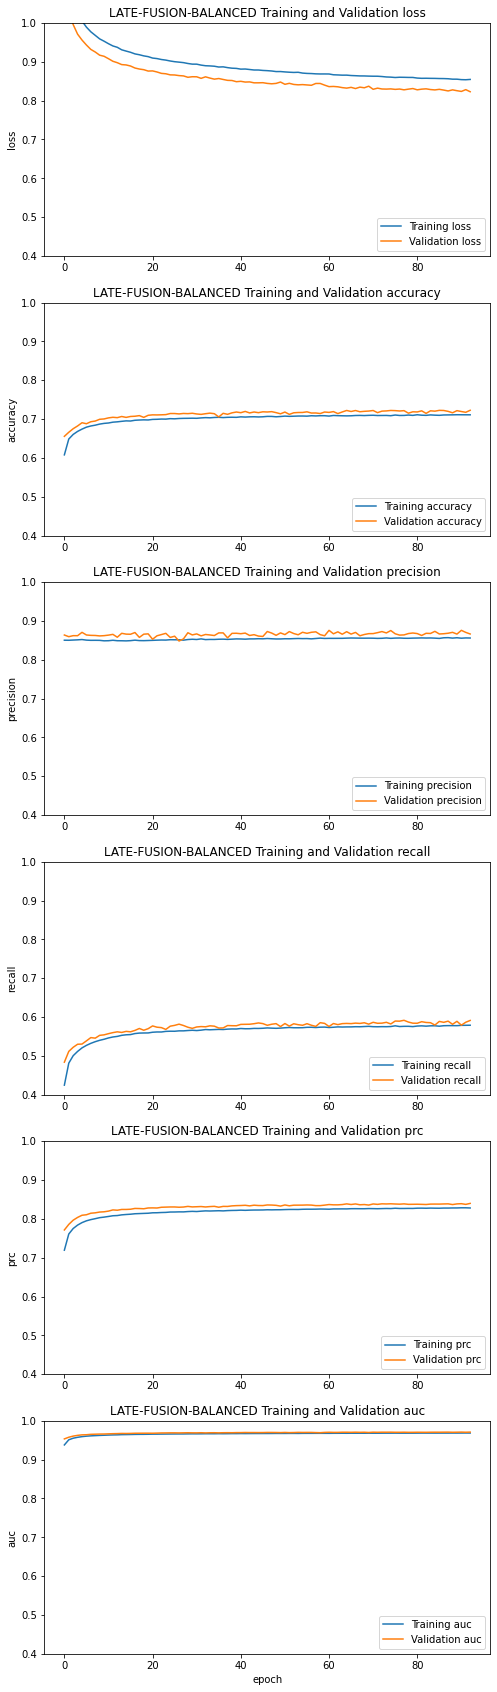

In [43]:
# LATE-FUSION-BALANCED
dataframe = resampled_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = resampled_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)
print('LATE-FUSION-BALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'LATE-FUSION-BALANCED')

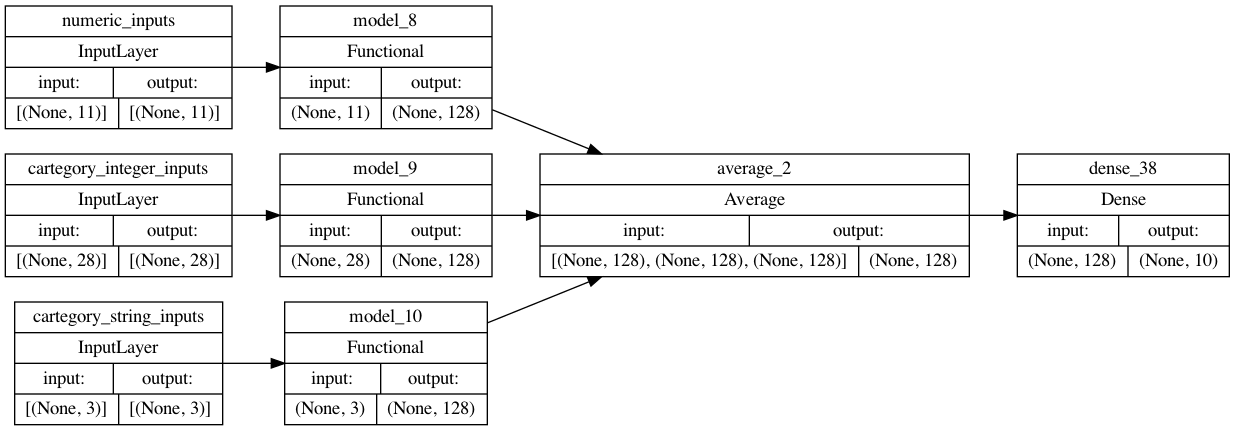

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [54]:
LATE_FUSION_RESULTS=MODELS_RESULTS

In [55]:
import pickle
with open('LATE_FUSION_RESULTS.dictionary', 'wb') as result_dictionary_file:
    pickle.dump(LATE_FUSION_RESULTS, result_dictionary_file)

In [12]:
project_name='HYPERPARAM_LATE-FUSION-IMBALANCED'
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
results_summary=tuner.results_summary(num_trials=1)
results_summary

INFO:tensorflow:Reloading Oracle from existing project hyperparam_dir/HYPERPARAM_LATE-FUSION-IMBALANCED/oracle.json
SUBMODAL-INTEGER-NUMERIC
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_inputs (InputLayer)  [(None, 11)]             0         
                                                                 
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_13 (Dense)            (None, 32)                384       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                  